# Importing libraries
**Os** : Used to handle files using system commands. \
**Pickle** : Used to store numpy features extracted.\
**numpy** : Used to perform a wide variety of mathematical operations on arrays. \
**tqdm** : Progress bar decorator for iterators.\
**tensorflow.keras**: Keras is a neural network Application Programming Interface (API) for Python that is tightly integrated with TensorFlow. \


In [17]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Directories
Base Directory contains the path of the Dataset \
Working Directory contains the path of Extracted features and saved Model 

In [18]:
BASE_DIR = r"C:\Users\exam01\Desktop\Deep Caption model\dataset"
WORKING_DIR = r"C:\Users\exam01\Desktop\Deep Caption model\work_dir"

# Extracting features from image
Example image: \
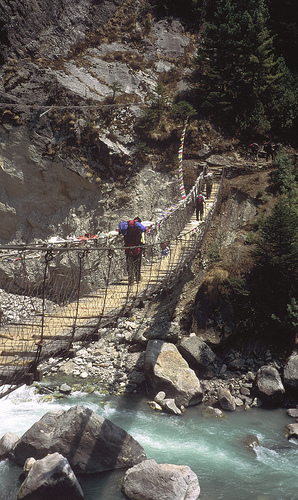 \
What VGG16 does: \
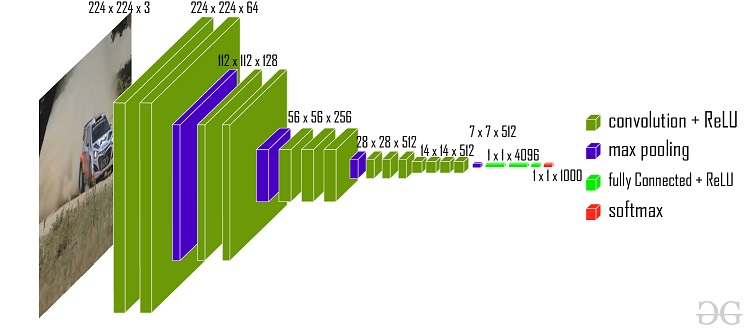

 **VGG16** is object detection and classification algorithm

In [19]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

What are features? \
A Feature is an individual measurable property or characteristic of a phenomenon \

Verbosity modes \
 0 = silent\
 1 = progress bar\
  2 = one line per epoch

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    

 64%|██████████████████████████████████████████████████▏                           | 5207/8092 [35:31<24:14,  1.98it/s]

# Storing Extracted Features

The **Pickle** module provides a way to convert Python objects into a binary format that can be stored in a file or transmitted over a network. This binary format can later be used to recreate the original Python object. \
"**wb**" mode opens the file in binary format for writing \
 "**rb**" option opens the file in binary format for reading. \


In [ ]:
 pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f1:
    features = pickle.load(f1)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
captions_doc

# Mapping Image to Captions

In [ ]:
# create mapping of image to captions
map_img = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    img_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    img_id = img_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if img_id not in map_img:
        map_img[img_id] = []
    # store the caption
    map_img[img_id].append(caption)

# Preprocessing captions

In [ ]:
def clean(map_img):
    for key, captions in map_img.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
  # before preprocess of text
map_img['1000268201_693b08cb0e']

In [ ]:
clean(map_img)

In [ ]:
  # after preprocess of text
map_img['1000268201_693b08cb0e']

In [ ]:
all_captions = []
for key in map_img:
    for caption in map_img[key]:
        all_captions.append(caption)

# Tokenizing
Turns each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary or based on word count.

fit_on_texts: It basically takes every unique word in the list of strings given to it and gives it an index 
This is  stored in toekizer.word_index dictionary

In [33]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [34]:
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'shirt': 35,
 'down': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'front': 47,
 'sitting': 48,
 'holding': 49,
 'up': 50,
 'field': 51,
 'small': 52,
 'by': 53,
 'a': 54,
 'large': 55,
 'green': 56,
 'one': 57,
 'group': 58,
 'yellow': 59,
 'her': 60,
 'walking': 61,
 'children': 62,
 'men': 63,
 'into': 64,
 'air': 65,
 'beach': 66,
 'near': 67,
 'mouth': 68,
 'jumps': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'runs': 73,
 'its': 74,
 'from': 75,

In [35]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Splitting training and testing set

In [37]:
image_ids = list(map_img.keys())
split = int(len(image_ids) * 0.90)
train_set = image_ids[:split]
test_set = image_ids[split:]  

# Generating data to give to model

In [38]:
#startseq little girl into wooden building endseq  
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building endseq

In [39]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, map_img, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = map_img[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
  

# Model structure

The **Rectified linear activation function** or **ReLU** for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

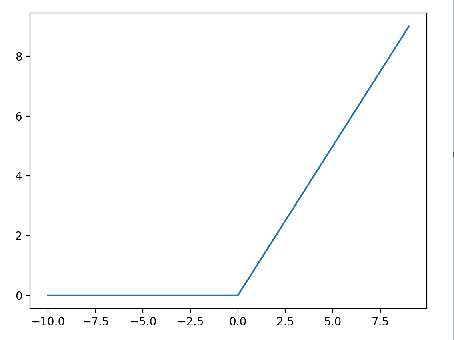


Dropout layer: Drops neurons randomly to prevent overfitting to a training dataset

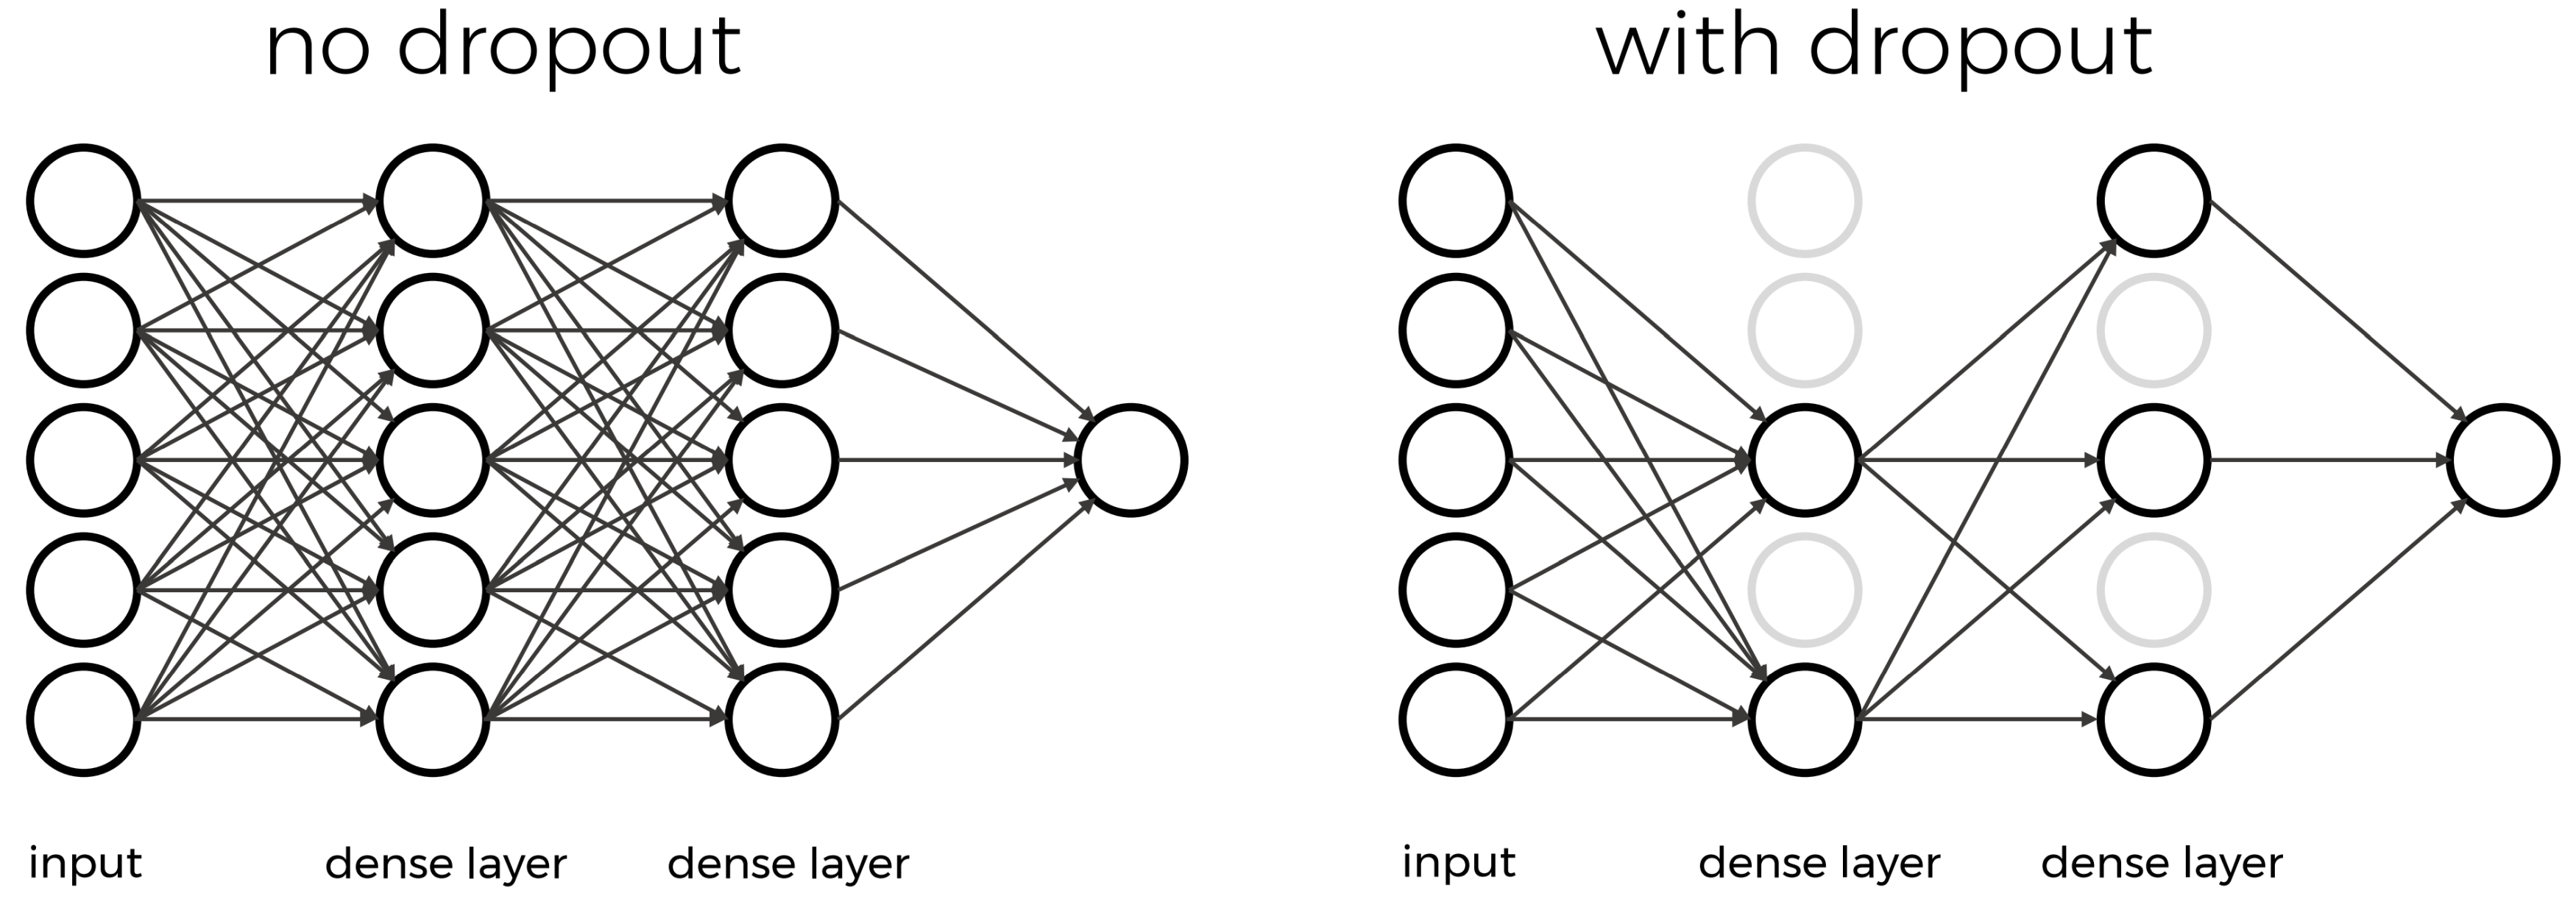

Dense Layer: A dense layer is a layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer. 

**Embedding**: Keras makes it easy to use word embeddings
by using the embedding layer. The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings).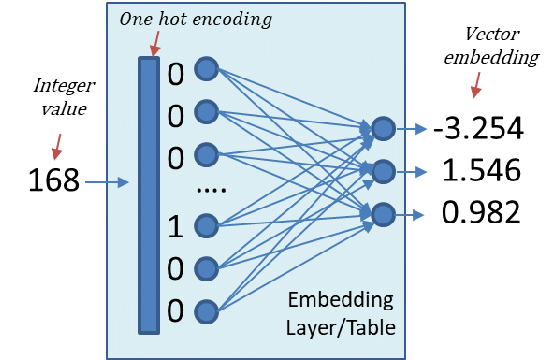  

The central role of an **LSTM model** is held by a memory cell known as a ‘cell state’ that maintains its state over time.

In [40]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


categorical_crossentropy - loss function for category outputs
optimizer=’adam’ - automatically adjust the learning rate for the model over the no. of epochs

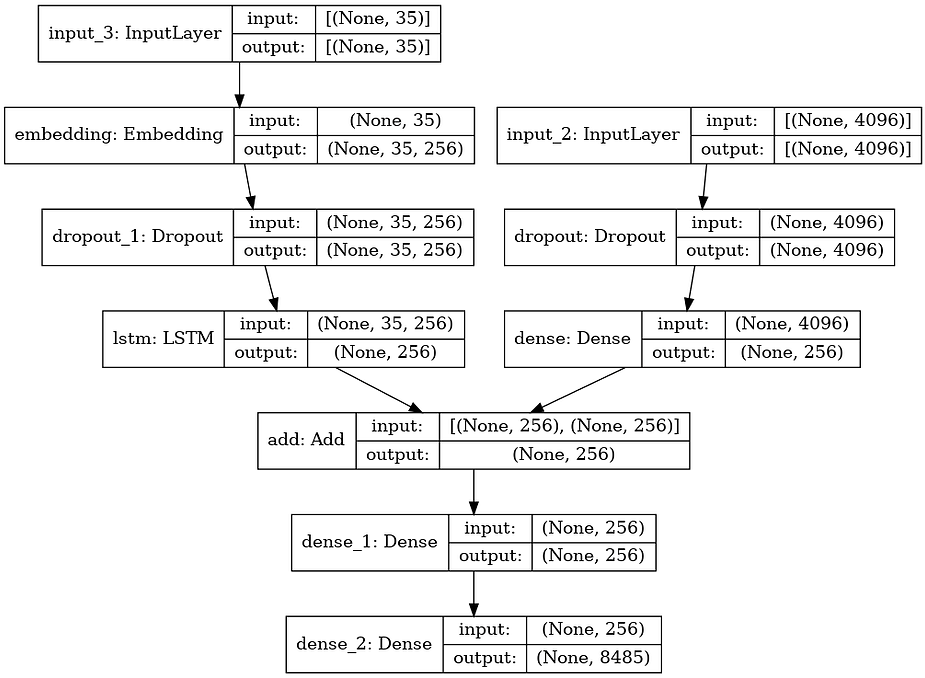

# Training the model

**Steps_per_epoch** determines the batches to train in a single dataset to improve the accuracy of the model


In [ ]:
# train the model
epochs = 15
batch_size = 64
steps = len(train_set) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_set, map_img, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 29/113 [======>.......................] - ETA: 15:20 - loss: 3.3646

# Saving and loading model

In [ ]:
#save the model
model.save(WORKING_DIR + '/model1.h5')

In [41]:
#load the model
from tensorflow.keras.models import load_model
model=load_model(WORKING_DIR+"/model.h5")
# (or)
# from tensorflow import keras
# model = keras.models.load_model(WORKING_DIR+"/suraj_best_model.h5")

Convert sequence to word

In [42]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Predict the caption

In [45]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    inp_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([inp_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        inp_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return inp_text

# Testing with test set

**BLEU Score** is used to evaluate the predicted text against a reference text, in a list of tokens. BLEU score is between 0 and 1.
A BLEU Score **more than 0.4** is considered a good result, for a better score increase the no. of epochs accordingly.

In [46]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_set):
    # get actual caption
    captions = map_img[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  3%|██▋                                                                              | 27/810 [00:13<06:21,  2.05it/s]


KeyboardInterrupt: 

# Testing with real data

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = map_img[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man in red coat and black coat in the snow endseq


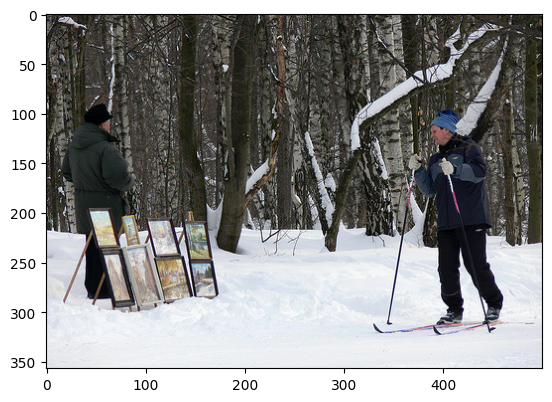

In [49]:
generate_caption("101669240_b2d3e7f17b.jpg")


In [52]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [53]:
image_path = BASE_DIR+ '/Images/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in red shirt is sitting on the wall endseq'

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq man in red shirt is sitting on the wall endseq


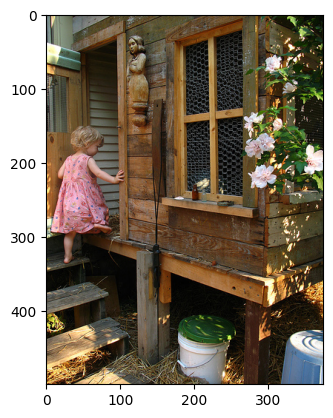